In [2]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np
import datetime

import swyft
from utils import *
from plot import *

from tqdm import tqdm
from data_mgmt import get_paths, get_ids
import pickle




DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 15})



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def restrictions(file, start, end):
    return (file.endswith(end) and file.startswith(start))

path = '../data/pred/'
files = os.listdir(path)
for file in files:
    if restrictions(file, 'pred_real', 'pickle'):
        full_path = os.path.join(path, file)
        print(full_path)

../data/pred/pred_real_m_1_nsub_1_nsim_50000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_50000_sigma_0.1_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_10000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_3_nsim_50000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_50000_sigma_0.5_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_5000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_real_m_1_nsub_1_nsim_100000_sigma_0.0_nmc_1_npred_0.pickle


In [4]:




m = 1
nsub = 1
# nsubs = [1, 3]
nsim = 50000
# nsims = [5000, 10000, 50000, 100000]
nmc = 1
npred = 0 #nsim
sigma = 0.0
# sigmas = [0.0, 0.1, 0.5, 1.0, 2.0, 100.0] 
sigmas = [0.0, 0.1, 0.5]
# sigmas = [0.0]
zero = 'real'

entries = []
for sigma in sigmas:
# for nsim in nsims:
    entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
    entries.append(entry)
    
    print(entry)
n_entries = len(entries)

{'m': 1, 'nsub': 1, 'nsim': 50000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'real'}
{'m': 1, 'nsub': 1, 'nsim': 50000, 'nmc': 1, 'sigma': 0.1, 'npred': 0, 'zero': 'real'}
{'m': 1, 'nsub': 1, 'nsim': 50000, 'nmc': 1, 'sigma': 0.5, 'npred': 0, 'zero': 'real'}


In [5]:
def get_pred(entry):
    _, _, _, pred_path = get_paths(entry)
    
    with open(pred_path, 'rb') as f:
        pred = pickle.load(f)
        
    posts, targets, obs0s, v0s, obs0_is = list(pred.values())
    return posts, targets, obs0s, v0s, obs0_is

posts_all = []
targets_all = []
obs0s_all = []
v0s_all = []
obs0_is_all = []

for entry in entries:
    posts, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    posts_all.append(posts)
    targets_all.append(targets)
    obs0s_all.append(obs0s)
    v0s_all.append(v0s)
    obs0_is_all.append(obs0_is)
    

In [6]:
def get_f(posts, targets, x):
    
    x1, x2 = x[:-1], x[1:]
        
    def f3(xi, xj):
        y = targets[(posts > xi) & (posts < xj)]
        return y.sum() / len(y) if y.sum() != 0 else 0

    return np.array([f3(xi, xj) for xi, xj in zip(x1, x2)])

In [7]:
def get_tc(i, v0, target):
    y, x, m = v0.reshape(-1, 3).T
#     m_i = np.where(target == 1)[0]
#     target_coords = np.array((m_i, x, y)).T
    
    m_i = np.full(len(x), i)
    target_coords = np.array((m_i, x, y)).T

    return target_coords

def get_target_coords(i, v0s):
    return np.concatenate([get_tc(j, v0s[j], targets[j]) for j in range(i)])

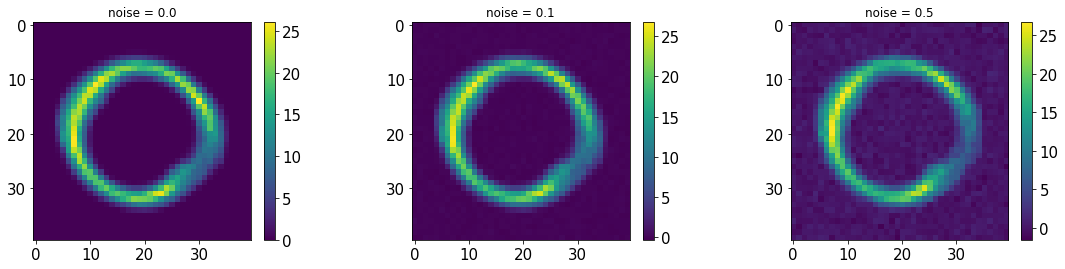

In [8]:
plt_imshow( np.array([obs0s[0] for obs0s in obs0s_all]),
#            nrows = 2,
           titles = [f"noise = {entry['sigma']}" for entry in entries], 
           cbar = True, tl = True, y = 4 )

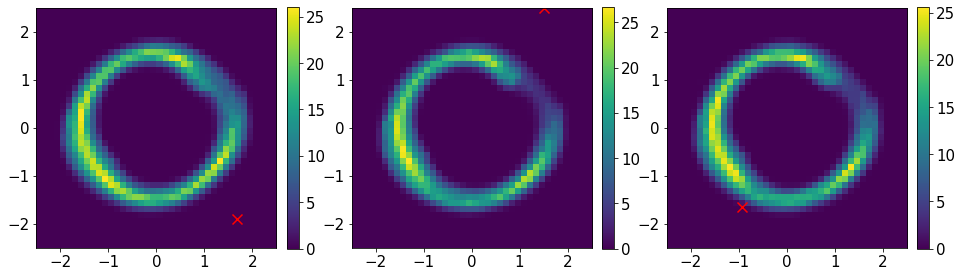

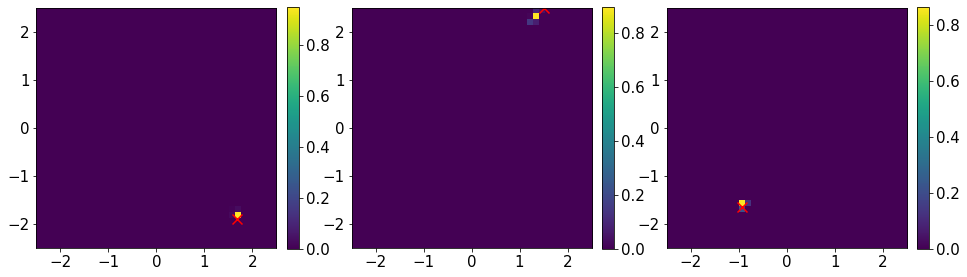

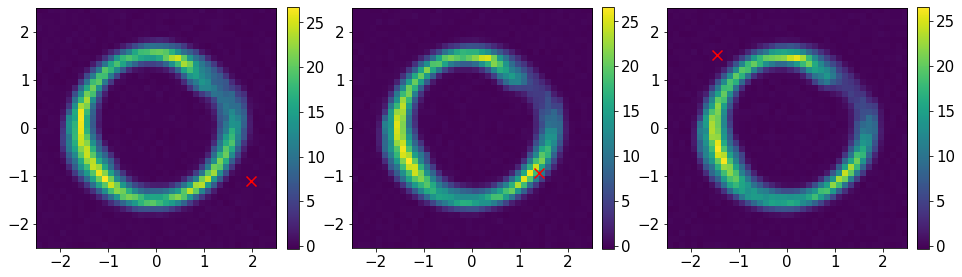

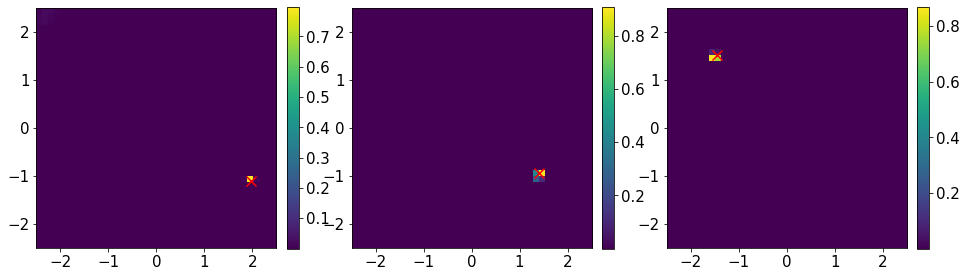

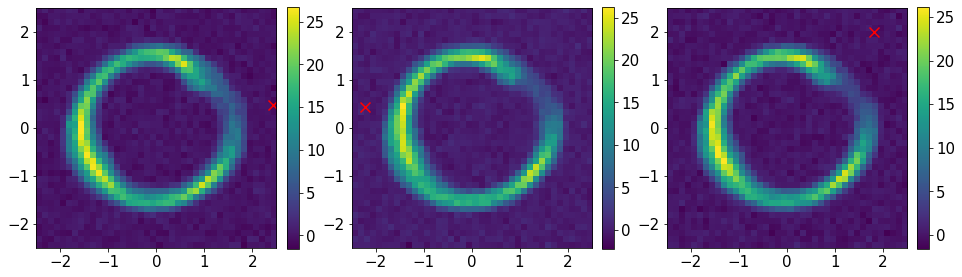

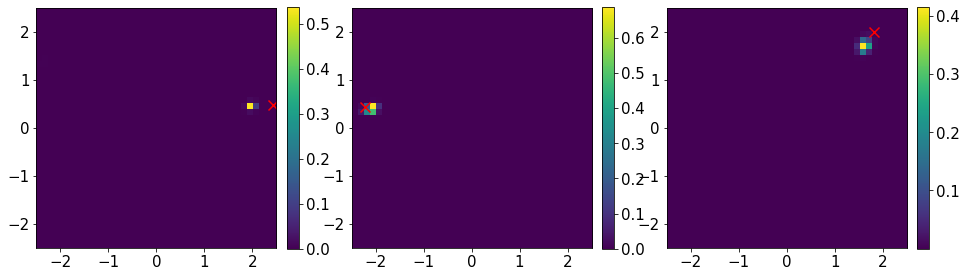

In [9]:

for entry in entries:
    posts, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    l = 3
    
    plt_imshow( obs0s[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)
    plt_imshow( posts.squeeze()[:l], target_coords = get_target_coords(l, v0s), **imkwargs, cbar = True)


In [10]:
def temp_prior(entries):
    L = 40
    priors =  [entry['nsub'] / (L*L) / entry['nmc']  for entry in entries]
    assert all([prior == priors[0] for prior in priors])
    return priors[0]
        
prior_freq = temp_prior(entries)

In [11]:
n_alpha = 50
alpha_edges = np.linspace(0, 1, n_alpha)
alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2

In [12]:
fs = np.array([get_f(posts, targets, alpha_edges) for posts, targets in zip(posts_all, targets_all)])


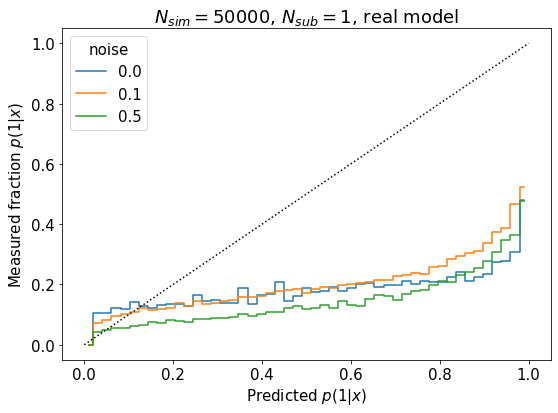

In [13]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6), tight_layout = True)

ax = axs

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for f, entry, color in zip(fs, entries, colors):
    ax.step(alpha_centers, f, label = f"{entry['sigma']}", where='mid', color = color)
ax.plot([0, 1], [0, 1], "k:")
# ax.plot([0, 1], [prior_freq, prior_freq], "k--")
ax.set_xlabel(r'Predicted $p(1|x)$')
ax.set_ylabel(r'Measured fraction $p(1|x)$')
ax.set_title(rf'$N_{{sim}} = {nsim}$, $N_{{sub}} = {nsub}$, {zero} model')
ax.legend(title = r'noise')

plt.show()

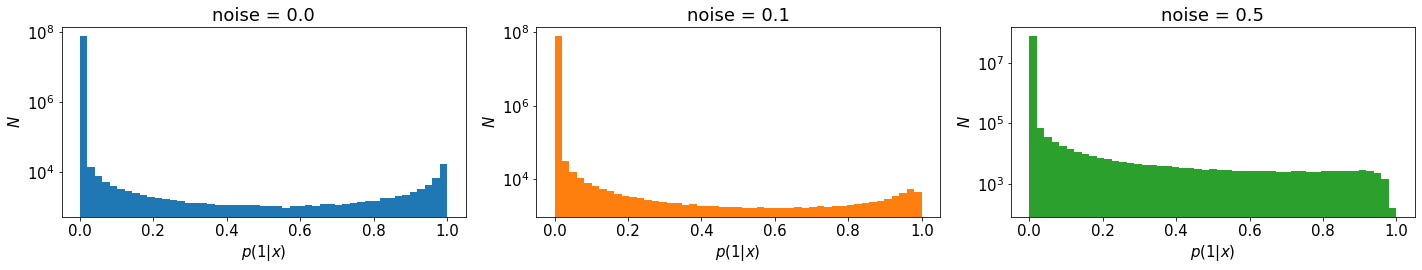

In [15]:
fig, axs = plt.subplots(1, n_entries, figsize = (20, 4), tight_layout = True)

# axs = [axs]
    
for ax, posts, entry, color in zip(axs, posts_all, entries, colors):
    ax.hist(posts.flatten(), bins = alpha_edges, color = color)
    ax.set_yscale('log')
    ax.set_xlabel(r'$p(1|x)$')
    ax.set_ylabel(r'$N$')
    ax.set_title(f"noise = {entry['sigma']}")
    

# for ax, entry, posts, color in zip(axs[-1:], entries[-1:], posts_all[-1:], colors[-1:]):
#     h, _, _  = ax.hist(posts[:10].flatten(), color = color)
#     ax.set_xlabel(r'$p(1|x)$')
#     ax.set_ylabel(r'$N$')
#     ax.set_title(rf"noise = {entry['sigma']}")
#     ax.axvline(x = prior_freq, ymin = 0, ymax = max(h))


plt.show()